This example shows how to use deep kernel learning (DKL) for classification. This is useful when you have very complex high-dimensional inputs (such as an image)

The example here is MNIST classification

For an introduction to DKL see these papers:
https://arxiv.org/abs/1511.02222
https://arxiv.org/abs/1611.00336

In [28]:
# Import our GPyTorch library
import gpytorch

# Import some classes we will use from torch
from torch.autograd import Variable
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

import torch
from torch import nn
from gpytorch.utils.lanczos_bidiagonalize import LanczosBidiagonalize

In [2]:
from dataloader import getDataloaders
config = {'augmentation': True}
train_loader, val_loader, test_loader = getDataloaders('cifar10', config)

In [30]:
from densenet import DenseNet
model = DenseNet()
state_dict = torch.load('pretrained_model_cifar10.model')
model.load_state_dict(state_dict)
#from torchvision.models import vgg
#model = vgg.vgg19(pretrained=True).cuda()

In [90]:
def get_activations_for_layer(input, model, layer):
    def hook(module, input, output):
        torch.save(output, 'tmp.pth')
    handle = layer.register_forward_hook(hook)
    model(input)
    handle.remove()
    activations = torch.load('tmp.pth')
    return activations

In [138]:
activations = get_activations_for_layer(Variable(train_loader.dataset[0][0].unsqueeze(0)).cuda(), model, model.features.denseblock3.denselayer5[1])
print(activations.shape, type(activations))

here
here
<class 'torch.nn.modules.activation.ReLU'>
torch.Size([1, 198, 8, 8]) <class 'torch.autograd.variable.Variable'>


In [139]:
probe = activations.data

In [145]:
def conv_to_dense(conv_layer, probe_img, rank):
    # probe_img should be 1 x in_channels x imgw x imgh
    imgw = probe_img.size(-2)
    imgh = probe_img.size(-1)
    in_channels = conv_layer.in_channels
    out_channels = conv_layer.out_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    
    probe_vector = probe_img.view(in_channels * imgw * imgh)
    if conv_layer.bias is not None:
        new_conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
        new_conv_layer.load_state_dict(conv_layer.state_dict(), strict=False)
    else:
        new_conv_layer = conv_layer
    new_conv_layer_t = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
    new_conv_layer_t.load_state_dict(new_conv_layer.state_dict(), strict=False)
    
    matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, imgw, imgh)).cuda()).data
    matmul_t_closure = lambda v: new_conv_layer_t(Variable(v.contiguous().view(1, out_channels, imgw, imgh)).cuda()).data
    
    lb = LanczosBidiagonalize(max_iter=rank, cls=type(probe_vector))
    n_rows = out_channels * imgw * imgh
    n_cols = in_channels * imgw * imgh
    P, B, Q = lb.lanczos_bidiagonalize(matmul_closure, matmul_t_closure, probe_vector, n_rows, n_cols)
    return P, B, Q, new_conv_layer

In [159]:
probe_img = probe.cuda()
P, B, Q, new_conv_layer = conv_to_dense(model.features.denseblock3.denselayer5[2].cuda(), probe_img, 3072)
print(P.shape, Q.shape)

/home/jrg365/anaconda3/lib/python3.6/site-packages/torch/tensor.py:300: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)


torch.Size([3072, 3072]) torch.Size([12672, 3072])


In [148]:
probe_img.shape

torch.Size([1, 198, 8, 8])

In [156]:
test_activations = get_activations_for_layer(Variable(train_loader.dataset[1][0].unsqueeze(0)).cuda(), model, model.features.denseblock3.denselayer5[1])
test_img = test_activations.data
my_out = P.matmul(B.matmul(Q.t().matmul(test_img.squeeze().view(198*8*8)))).view(1, 48, 8, 8)
real_out = new_conv_layer(Variable(test_img).cuda()).data

here
here
<class 'torch.nn.modules.activation.ReLU'>


In [157]:
my_out[0, 0]


-0.1250  0.0026 -0.0473 -0.0353 -0.0448 -0.0962 -0.0021  0.0123
 0.0178 -0.0614 -0.0093 -0.0355 -0.0729 -0.0161 -0.0051 -0.0250
-0.1447 -0.0723 -0.0676 -0.0549 -0.0005 -0.0581 -0.0375 -0.0482
-0.0109 -0.0548 -0.0553 -0.0089 -0.0472 -0.0536 -0.0169 -0.0889
-0.0564 -0.0594 -0.0045 -0.0164 -0.0094 -0.0766 -0.1041 -0.0090
-0.0422 -0.0196 -0.0061  0.0264 -0.1042  0.0254 -0.0110 -0.0300
-0.0690  0.0158 -0.0854 -0.0029  0.0328  0.0349 -0.0863 -0.0858
-0.0154  0.0519  0.0366 -0.0388 -0.0065  0.0080  0.0472  0.0171
[torch.cuda.FloatTensor of size 8x8 (GPU 0)]

In [158]:
real_out[0, 0]


 0.0149 -0.0315  0.0101  0.0733  0.0511  0.0004 -0.0502 -0.0707
 0.0905 -0.0058 -0.1271 -0.1657 -0.1687  0.0193 -0.1864 -0.1879
-0.0376 -0.1278 -0.1538 -0.0997 -0.0217 -0.0788 -0.0863 -0.0827
 0.0570 -0.0993 -0.0816  0.0339 -0.1375 -0.1127 -0.1114 -0.1262
-0.0777 -0.1016  0.0074  0.0817 -0.0383 -0.0702 -0.1327 -0.1485
-0.1627 -0.1850 -0.0137  0.0106 -0.0458 -0.0159 -0.0599 -0.0070
-0.0851 -0.0188 -0.0315 -0.0357  0.0071 -0.1055 -0.1372 -0.0579
 0.0462  0.0232  0.0467  0.1788 -0.0784 -0.1566  0.0012 -0.0032
[torch.cuda.FloatTensor of size 8x8 (GPU 0)]

In [132]:
svs = Out[131][1]

## Define the feature extractor for our deep kernel

In [160]:
# probe_img should be 1 x in_channels x imgw x imgh
conv_layer = model.features.denseblock3.denselayer5[2]
rank = 100
imgw = probe_img.size(-2)
imgh = probe_img.size(-1)
in_channels = conv_layer.in_channels
out_channels = conv_layer.out_channels
kernel_size = conv_layer.kernel_size
stride = conv_layer.stride
padding = conv_layer.padding

probe_vector = torch.randn(in_channels * 8 * 8)

new_conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
new_conv_layer.load_state_dict(conv_layer.state_dict(), strict=False)
new_conv_layer_t = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
new_conv_layer_t.load_state_dict(new_conv_layer.state_dict(), strict=False)

matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, imgw, imgh)).cuda()).data
matmul_t_closure = lambda v: new_conv_layer_t(Variable(v.contiguous().view(1, out_channels, imgw, imgh)).cuda()).data

lb = LanczosBidiagonalize(max_iter=rank, cls=type(probe_vector))
n_rows = out_channels * imgw * imgh
n_cols = in_channels * imgw * imgh

In [161]:
tmp_matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(16, in_channels, 8, 8))).data
tmp_single_matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, 8, 8)).cuda()).data
full_matrix = torch.zeros(out_channels * 8 * 8, in_channels * 8 * 8)
#tmp_matmul_closure(torch.eye(32768))

In [166]:
12672/16

792.0

In [167]:
query = torch.eye(12672)
for i in range(792):
    iquery = query[i*16:(i+1)*16, :]
    mv_result = tmp_matmul_closure(iquery.cuda()) # 16 x out_channels x 8 x 8
    full_matrix[:, i*16:(i+1)*16] = mv_result.view(16, out_channels * 8 * 8).t()

In [169]:
v = torch.randn(12672)
foo = full_matrix.matmul(v).view(1, 48, 8, 8)
bar = tmp_single_matmul_closure(v)

In [170]:
foo[0, 0]


-0.4162  1.0801 -0.3112  0.5306 -0.6344  0.8932  0.5655 -0.4148
-0.1490 -0.3986 -0.5153  0.3185  0.1137  0.5429  1.1271  0.8324
-0.6271 -0.6273 -0.1703 -0.4854  0.1000  0.3816  0.9990  0.4768
 0.7832 -0.4838  0.5524  0.6123  0.7270  0.9457 -0.4304 -0.3675
 0.4251 -0.6419 -0.6681 -0.3972 -0.4339 -0.5961  1.1134  0.4202
 0.4582 -0.2432 -1.1304 -0.6372 -0.8509 -0.3806  0.7256 -1.0742
-0.5626 -0.7196  1.2833  0.7704 -0.7007  0.7098  0.5523 -0.8401
 0.2674 -0.2597 -0.2632 -0.0344  0.0071 -0.0151 -0.8089 -0.5882
[torch.FloatTensor of size 8x8]

In [171]:
bar[0, 0]


-0.4162  1.0801 -0.3112  0.5306 -0.6344  0.8932  0.5655 -0.4148
-0.1490 -0.3986 -0.5153  0.3185  0.1137  0.5429  1.1271  0.8324
-0.6271 -0.6273 -0.1703 -0.4854  0.1000  0.3816  0.9990  0.4768
 0.7832 -0.4838  0.5524  0.6123  0.7270  0.9457 -0.4304 -0.3675
 0.4251 -0.6419 -0.6681 -0.3972 -0.4339 -0.5961  1.1134  0.4202
 0.4582 -0.2432 -1.1304 -0.6372 -0.8509 -0.3806  0.7256 -1.0742
-0.5626 -0.7196  1.2833  0.7704 -0.7007  0.7098  0.5523 -0.8401
 0.2674 -0.2597 -0.2632 -0.0344  0.0071 -0.0151 -0.8089 -0.5882
[torch.cuda.FloatTensor of size 8x8 (GPU 0)]

In [173]:
full_matrix_gpu = full_matrix.cuda()

In [179]:
svs = full_matrix_gpu.svd()[1]

In [180]:
from matplotlib import pyplot as plt
%matplotlib inline

Text(0,0.5,'singular value')

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


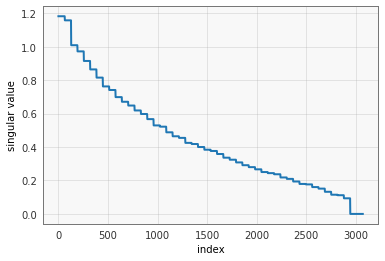

In [181]:
plt.plot(list(range(3072)), svs.cpu().numpy())
plt.xlabel('index')
plt.ylabel('singular value')

Text(0,0.5,'singular value')

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


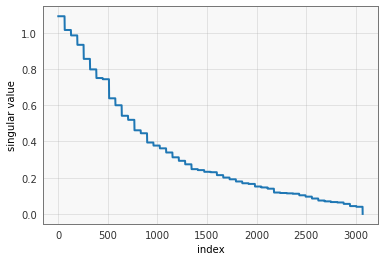

In [136]:
plt.plot(list(range(3072)), svs.cpu().numpy())
plt.xlabel('index')
plt.ylabel('singular value')